## Description

When you have a broken arm, radiologists help save the day—and the bone. These doctors diagnose and treat medical conditions using imaging techniques like CT and PET scans, MRIs, and, of course, X-rays. Yet, as it happens when working with such a wide variety of medical tools, radiologists face many daily challenges, perhaps the most difficult being the chest radiograph. The interpretation of chest X-rays can lead to medical misdiagnosis, even for the best practicing doctor. Computer-aided detection and diagnosis systems (CADe/CADx) would help reduce the pressure on doctors at metropolitan hospitals and improve diagnostic quality in rural areas.

Existing methods of interpreting chest X-ray images classify them into a list of findings. There is currently no specification of their locations on the image which sometimes leads to inexplicable results. A solution for localizing findings on chest X-ray images is needed for providing doctors with more meaningful diagnostic assistance.

Established in August 2018 and funded by the Vingroup JSC, the Vingroup Big Data Institute (VinBigData) aims to promote fundamental research and investigate novel and highly-applicable technologies. The Institute focuses on key fields of data science and artificial intelligence: computational biomedicine, natural language processing, computer vision, and medical image processing. The medical imaging team at VinBigData conducts research in collecting, processing, analyzing, and understanding medical data. They're working to build large-scale and high-precision medical imaging solutions based on the latest advancements in artificial intelligence to facilitate effective clinical workflows.

In this competition, you’ll automatically localize and classify 14 types of thoracic abnormalities from chest radiographs. You'll work with a dataset consisting of 18,000 scans that have been annotated by experienced radiologists. You can train your model with 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images. These annotations were collected via VinBigData's web-based platform, VinLab. Details on building the dataset can be found in our recent paper “VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.

If successful, you'll help build what could be a valuable second opinion for radiologists. An automated system that could accurately identify and localize findings on chest radiographs would relieve the stress of busy doctors while also providing patients with a more accurate diagnosis.

## Code for downsampling images



```
import numpy as np
import pydicom
import cv2
import os
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = True, fix_monochrome = True, downscale_factor = 4):
    dicom = pydicom.read_file(path)

    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255.0).astype(np.uint8)
    new_shape = tuple([int(x / downscale_factor) for x in data.shape])
    data = cv2.resize(data, (new_shape[1], new_shape[0]))

    return data

ftrain = os.listdir('/home/db/train')
ftest = os.listdir('/home/db/test')

for i in range(len(ftrain)):
    img = read_xray('/home/db/train/'+ftrain[i])
    cv2.imwrite('/mnt/data/vinbigdata/train/'+ftrain[i].replace('.dicom','.jpg'), img)

for i in range(len(ftest)):
    img = read_xray('/home/db/test/'+ftest[i])
    cv2.imwrite('/mnt/data/vinbigdata/test/'+ftest[i].replace('.dicom','.jpg'), img)   
```



## General imports

In [124]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import seaborn as sns
import warnings
from skimage import exposure
import albumentations
warnings.filterwarnings('ignore')

In [33]:
TRAIN_DIR = './train/train'
TEST_DIR = './test/test'

## Tabular data overview

In [6]:
train = pd.read_csv('train_downsampled.csv')
submission = pd.read_csv(os.path.join('sample_submission.csv'))

**Dataset information**

The dataset comprises 18,000 postero-anterior (PA) CXR scans in DICOM format (we will use images converted from DICOM to jpeg format), which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of 14 critical radiographic findings as listed below:

0. - Aortic enlargement
1. - Atelectasis
2. - Calcification
3. - Cardiomegaly
4. - Consolidation
5. - ILD
6. - Infiltration
7. - Lung Opacity
8. - Nodule/Mass
9. - Other lesion
10. - Pleural effusion
11. - Pleural thickening
12. - Pneumothorax
13. - Pulmonary fibrosis


The "No finding" observation (14) was intended to capture the absence of all findings above.

**Files**


    train.csv - the train set metadata, with one row for each object, including a class and a bounding box. Some images in both test and train have multiple objects.
    train_downsampled.csv - the train set metadata, with one row for each object, including a class and a bounding box. Some images in both test and train have multiple objects (containes adjusted x_min, y_min, x_max, y_max after downsampling)

In [7]:
train.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

   x_min  y_min  x_max  y_max  
0    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN  
2  172.0  343.0  413.0  457.0  
3  316.0  185.0  402.0  254.0  
4    NaN    NaN    NaN    NaN

In [8]:
train.tail()


image_id    class_name  class_id rad_id  x_min  \
67909  936fd5cff1c058d39817a08f58b72cae    No finding        14     R1    NaN   
67910  ca7e72954550eeb610fe22bf0244b7fa    No finding        14     R1    NaN   
67911  aa17d5312a0fb4a2939436abca7f9579    No finding        14     R8    NaN   
67912  4b56bc6d22b192f075f13231419dfcc8  Cardiomegaly         3     R8  192.0   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c    No finding        14    R16    NaN   

       y_min  x_max  y_max  
67909    NaN    NaN    NaN  
67910    NaN    NaN    NaN  
67911    NaN    NaN    NaN  
67912  244.0  420.0  327.0  
67913    NaN    NaN    NaN

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [53]:
train.shape

(67914, 8)

In [10]:
submission.head()

image_id PredictionString
0  002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1  004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2  008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1
3  009bc039326338823ca3aa84381f17f1     14 1 0 0 1 1
4  00a2145de1886cb9eb88869c85d74080     14 1 0 0 1 1

In [11]:
submission.tail()

image_id PredictionString
2995  ff91fb82429a27521bbec8569b041f02     14 1 0 0 1 1
2996  ff9fcc4087ed5e941209aa3fa948e364     14 1 0 0 1 1
2997  ffaa288c8abca300974f043b57d81521     14 1 0 0 1 1
2998  ffc441e0c8b7153844047483a577e7c3     14 1 0 0 1 1
2999  ffccf1709d0081d122a1d1f9edbefdf1     14 1 0 0 1 1

**Distribution of target variable**

Our goal is to predict class_id (meanings of what id is representing in column class_name)

Text(0.5, 1.0, 'Class distribution')

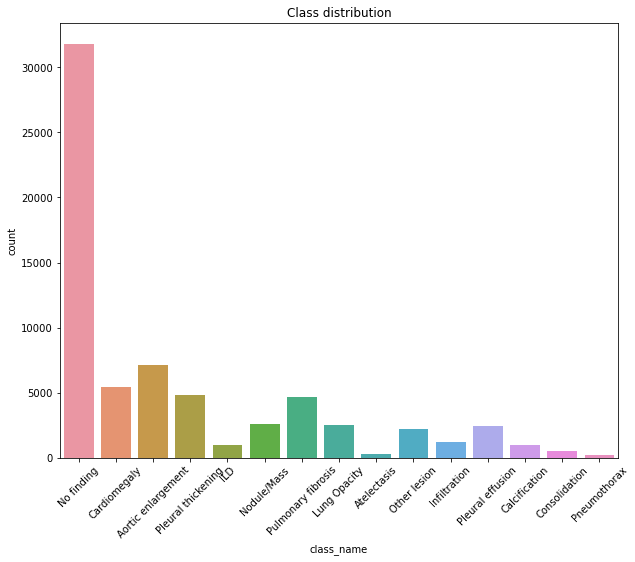

In [12]:
plt.figure(figsize = (10, 8))
sns.countplot(train['class_name'])
plt.xticks(rotation=45)
plt.title('Class distribution')

In [46]:
images_no_finding = set(train.loc[train['class_name'] == 'No finding', 'image_id'])
images_finding = set(train.loc[train['class_name'] != 'No finding', 'image_id'])

In [51]:
images_no_finding.intersection(images_finding)

set()

In [52]:
train.shape

(67914, 8)

In [13]:
train['class_name'].value_counts(normalize = True)

No finding            0.468504
Aortic enlargement    0.105457
Cardiomegaly          0.079910
Pleural thickening    0.071296
Pulmonary fibrosis    0.068543
Nodule/Mass           0.037989
Lung Opacity          0.036561
Pleural effusion      0.036458
Other lesion          0.032438
Infiltration          0.018361
ILD                   0.014725
Calcification         0.014136
Consolidation         0.008187
Atelectasis           0.004108
Pneumothorax          0.003328
Name: class_name, dtype: float64

We could see that actually some classes appeard less than in 1% cases

Let's see how many unique images we have 

In [14]:
train['image_id'].nunique()

15000

So far we have 15000 images for training.

**Check missing values**

In [15]:
train.isnull().sum()

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
dtype: int64

We can see that class 'No findings' don't have any boxes which looks reasonable.

## Train images EDA

**Check train images**

In [16]:
def check_images_corruption(images_list: np.ndarray, images_path: str, threshold: int=2):
    """ Check images for wrong shapes reading error & black screen images """
    for ind, imagename in tqdm(enumerate(images_list), total = images_list.shape[0]):
        image_path = os.path.join(images_path, imagename)

        image_cv2 = cv2.imread(image_path)
        width, height = Image.open(image_path).size

        message = f"Image '{imagename}' with index '{ind}' shape is wrong! " \
                  f"Shape from Pillow: {(width, height)}, shape from OpenCV: {image_cv2.shape[:2]}"

        assert width == image_cv2.shape[1] and height == image_cv2.shape[0], message
        assert np.unique(image_cv2).shape[0] >= threshold, f"Image '{imagename}' is corrupted!"

    print('Images are clear.')

def get_images_metainfo(images_list: np.ndarray, images_path: str):
    """Read metadata of images
    Returns:
        List: list of dicts with keys: imagename,
            width, height, aspect_ratio.
    """
    metainfo = []

    for imagename in tqdm(images_list, total = images_list.shape[0]):
        current_meta = {
            'imagename': imagename,
        }

        image_path = os.path.join(images_path, imagename)
        width, height = Image.open(image_path).size

        current_meta['width'] = width
        current_meta['height'] = height
        current_meta['aspect_ratio'] = width/height
        metainfo.append(current_meta)

    return metainfo

In [37]:
check_images_corruption(images_list, TRAIN_DIR)


Images are clear.


In [68]:
meta_info_df = pd.DataFrame(get_images_metainfo(images_list, TRAIN_DIR))

In [69]:
meta_info_df['imagename'] = meta_info_df['imagename'].map(lambda x: str(x).replace('.jpg', ''))

In [70]:
meta_info_df.head()

imagename  width  height  aspect_ratio
0  000434271f63a053c4128a0ba6352c7f    584     709      0.823695
1  00053190460d56c53cc3e57321387478    498     607      0.820428
2  0005e8e3701dfb1dd93d53e2ff537b6e    768     768      1.000000
3  0006e0a85696f6bb578e84fafa9a5607    750     750      1.000000
4  0007d316f756b3fa0baea2ff514ce945    576     720      0.800000

<AxesSubplot:>

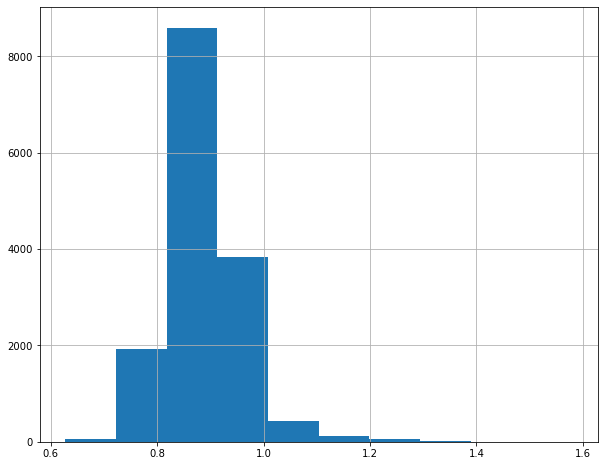

In [43]:
plt.figure(figsize = (10, 8))
meta_info_df['aspect_ratio'].hist()

**Images with presented abnormaly**

In [71]:
finding_df = train[train['class_name'] != 'No finding']

In [72]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

finding_df['bbox_area'] = finding_df.apply(get_bbox_area, axis=1)
finding_df.head()

image_id          class_name  class_id rad_id  \
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
5  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
6  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
7  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

   x_min  y_min  x_max  y_max  bbox_area  
2  172.0  343.0  413.0  457.0    27474.0  
3  316.0  185.0  402.0  254.0     5934.0  
5  156.0   89.0  236.0  108.0     1520.0  
6  336.0   61.0  547.0  542.0   101491.0  
7  139.0  588.0  168.0  621.0      957.0

In [73]:
finding_df = finding_df.merge(meta_info_df, left_on = 'image_id', right_on = 'imagename', how = 'inner')

In [74]:
finding_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  9a5094b2563a1ef3ff50dc5c7ff71345    Pleural effusion        10     R9   
2  9a5094b2563a1ef3ff50dc5c7ff71345  Pleural thickening        11     R9   
3  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3     R9   
4  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3     R8   

   x_min  y_min  x_max  y_max  bbox_area                         imagename  \
0  172.0  343.0  413.0  457.0    27474.0  9a5094b2563a1ef3ff50dc5c7ff71345   
1  447.0  432.0  468.0  498.0     1386.0  9a5094b2563a1ef3ff50dc5c7ff71345   
2  447.0  432.0  468.0  498.0     1386.0  9a5094b2563a1ef3ff50dc5c7ff71345   
3  173.0  343.0  414.0  449.0    25546.0  9a5094b2563a1ef3ff50dc5c7ff71345   
4  172.0  328.0  416.0  440.0    27328.0  9a5094b2563a1ef3ff50dc5c7ff71345   

   width  height  aspect_ratio  
0    520     584      0.890411  
1    520     584      0.890411  
2    520     584      0.890411  
3    520     584      0.890411  
4    520     584      0.890411

In [75]:
finding_df['image_area'] = finding_df['width']*finding_df['height']

In [76]:
finding_df['percent_covered'] = finding_df['bbox_area']/finding_df['image_area']

<AxesSubplot:>

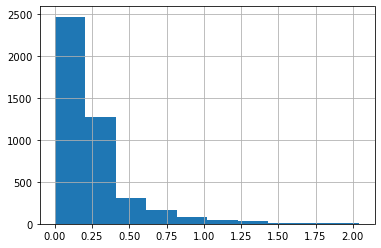

In [77]:
finding_df.groupby('image_id')['percent_covered'].agg(np.sum).hist()

Text(0.5, 1.0, 'Boxes area distribution')

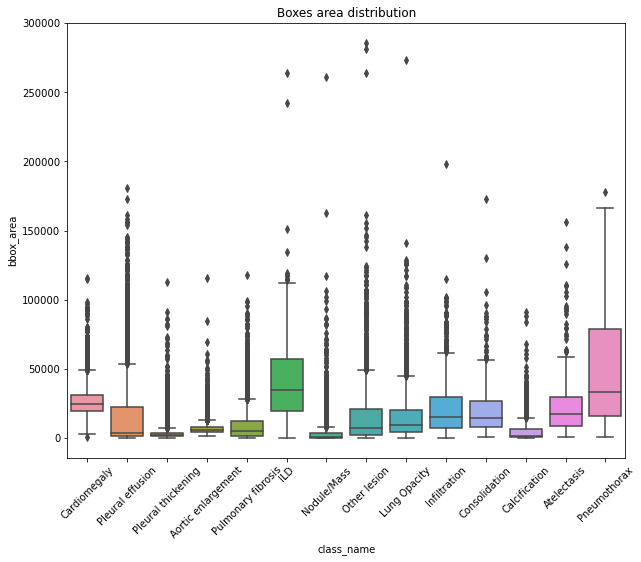

In [147]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = finding_df['class_name'], y = finding_df['bbox_area'])
plt.xticks(rotation=45)
plt.title('Boxes area distribution')

In [148]:
grouped = finding_df.groupby('class_name')['bbox_area'].mean().reset_index()

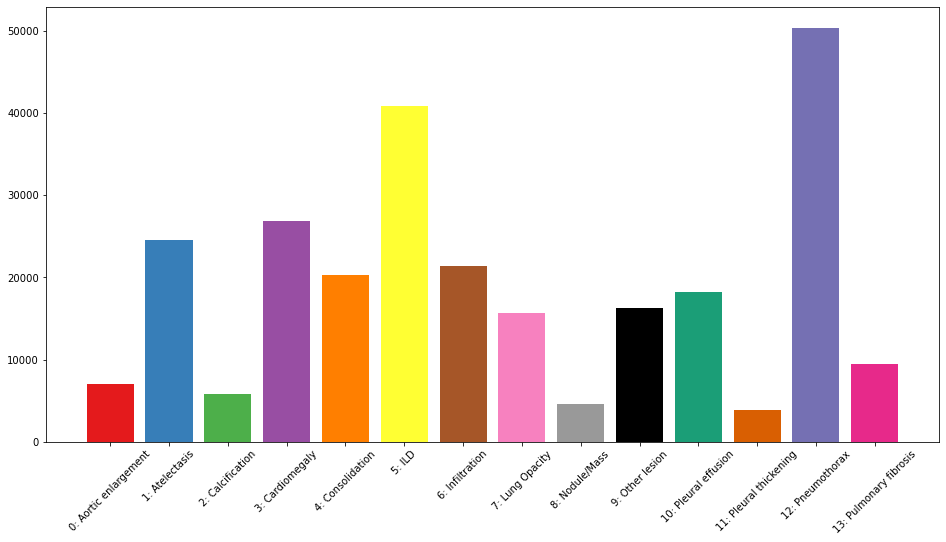

In [149]:
cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']
plt.figure(figsize=(16, 8));
plt.bar(grouped['class_name'], grouped['bbox_area'], 
        tick_label=[str(i) + ': ' + label_dict[i] for i in range(14)],
        color=cols);
plt.xticks(rotation=45);

**Number of bounding boxes per image**

In [114]:
finding_df['boxes_count'] = finding_df.groupby('image_id')['percent_covered'].transform(lambda x: len(x))

In [115]:
finding_df['boxes_count'].max(), finding_df['boxes_count'].min()

(57.0, 3.0)

## Images with percent of area covered by boxes less than 25%

In [78]:
finding_df['percent_covered'] = finding_df.groupby('image_id')['percent_covered'].transform(np.sum)

In [79]:
finding_df_small = finding_df.loc[finding_df['percent_covered'] < 0.25,:]

In [80]:
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

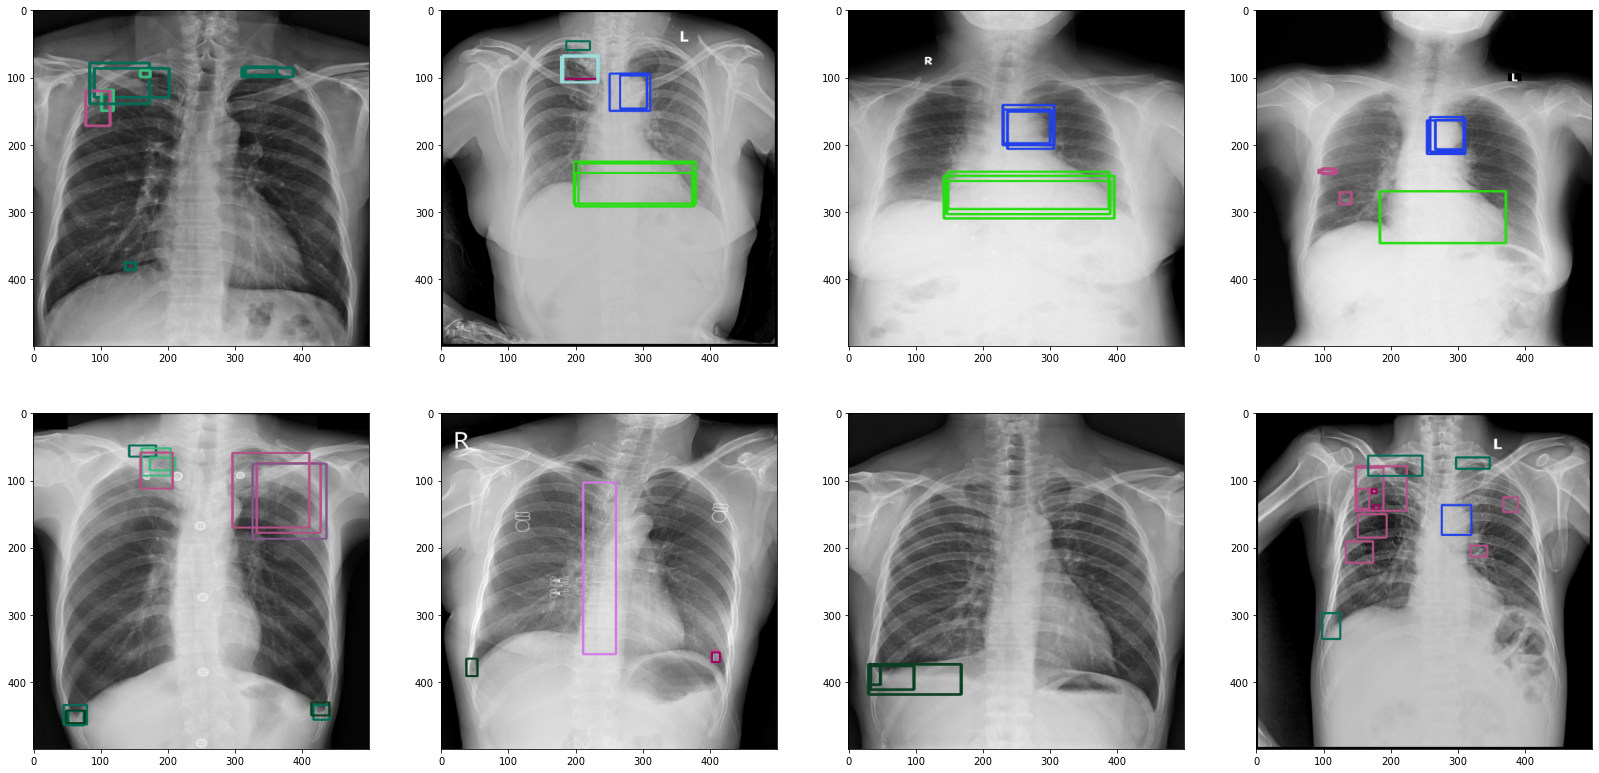

In [97]:
imgs = []
img_ids = finding_df_small['image_id'].values
class_ids = finding_df_small['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[np.random.randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img = cv2.imread(TRAIN_DIR + '/' + img_id + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    boxes = finding_df_small.loc[finding_df_small['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    labels = finding_df_small.loc[finding_df_small['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

## Images with percent of boxes more than 75%

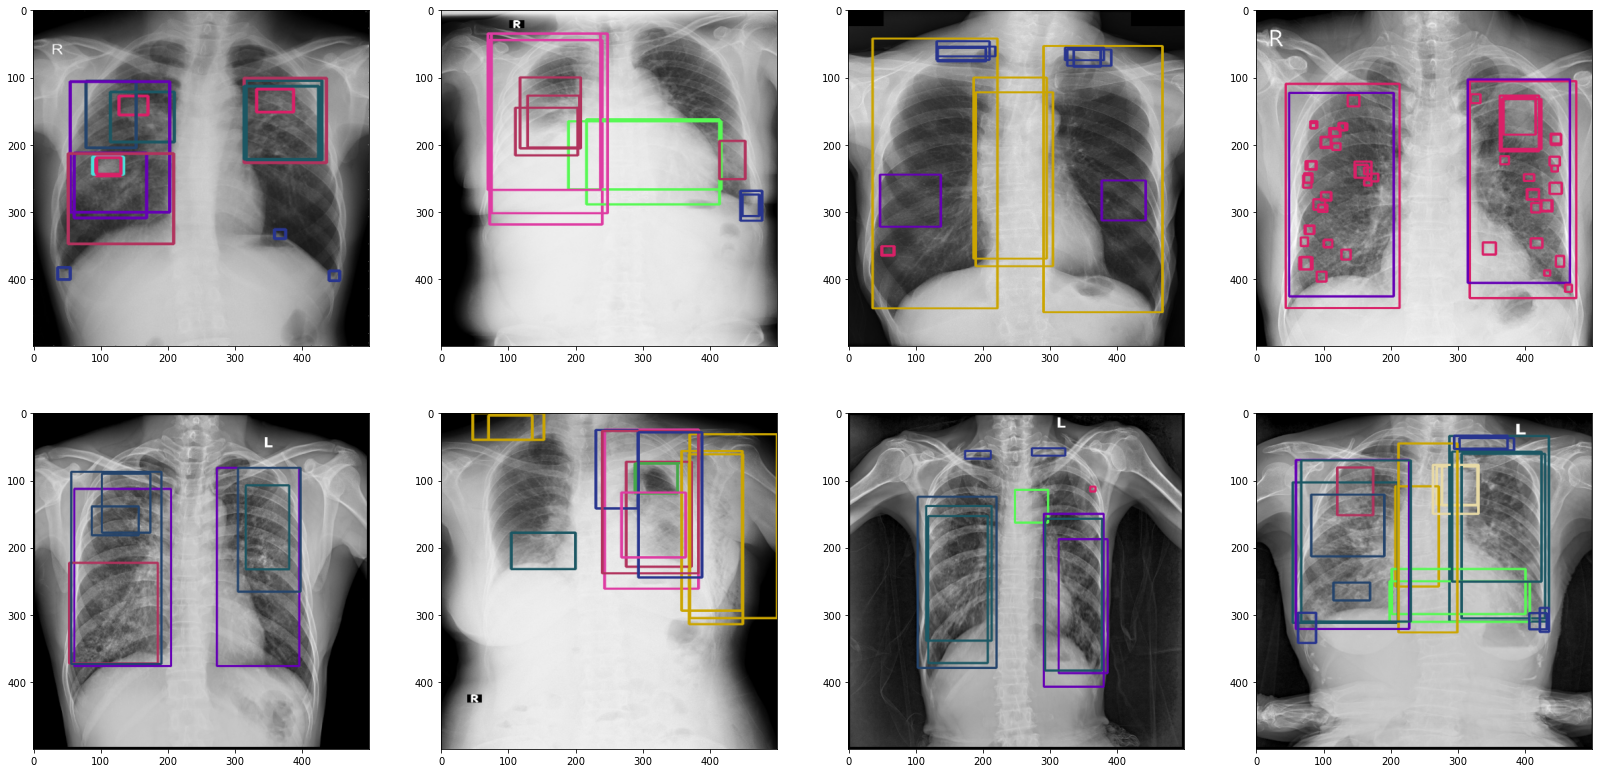

In [98]:
finding_df_big = finding_df.loc[finding_df['percent_covered'] > 0.75,:]
imgs = []
img_ids = finding_df_big['image_id'].values
class_ids = finding_df_big['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[np.random.randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img = cv2.imread(TRAIN_DIR + '/' + img_id + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    boxes = finding_df_big.loc[finding_df_big['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    labels = finding_df_big.loc[finding_df_big['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

## Images without findings


In [99]:
no_finding_df = train[train['class_name'] != 'No finding']

In [100]:
images_list = no_finding_df['image_id'].unique()

In [106]:
imgs = []
for i in images_list[:10]:
    img = cv2.imread(TRAIN_DIR + '/' + i + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500,500))
    imgs.append(img)

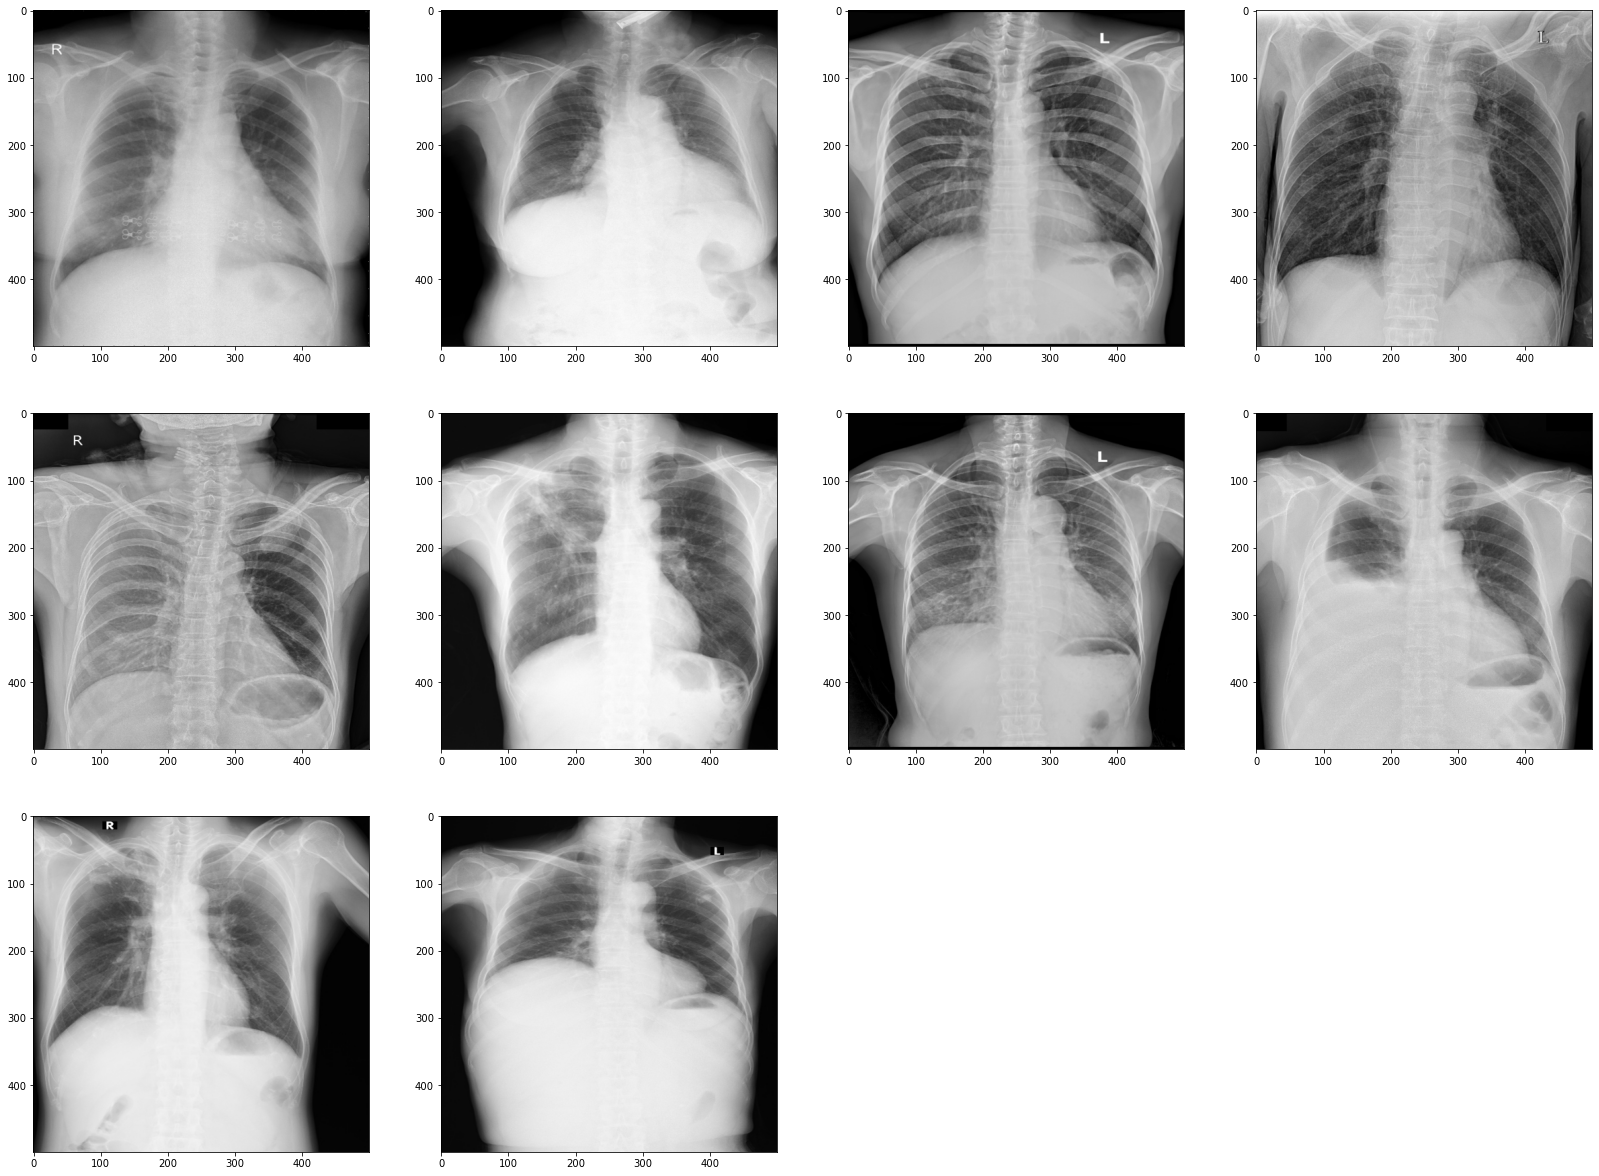

In [107]:
plot_imgs(imgs)

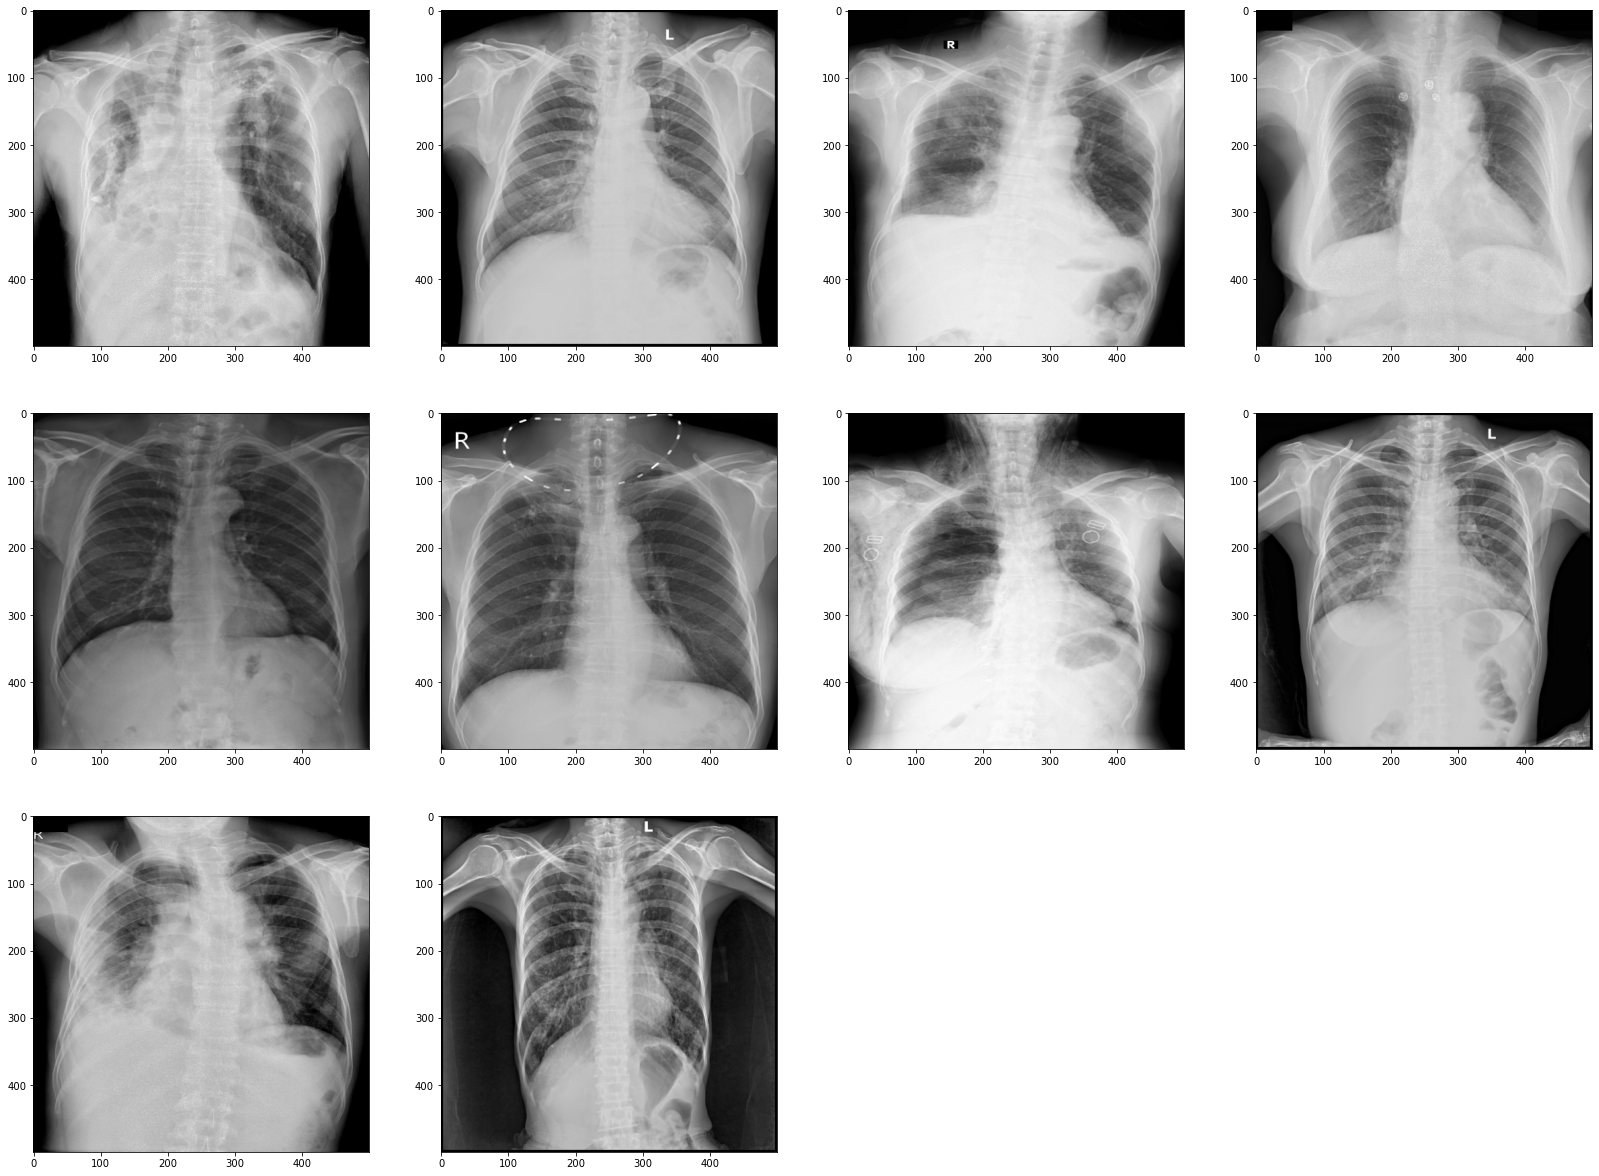

In [108]:
imgs = []
for i in images_list[10:20]:
    img = cv2.imread(TRAIN_DIR + '/' + i + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs)

## Location of different findings

In [109]:
locations = np.zeros((14, int(np.ceil(np.max(train.y_max)/10)*10), int(np.ceil(np.max(train.x_max)/10)*10)))
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    if row['class_id']<14:
        locations[row['class_id'], int(row['y_min']):int(row['y_max']+1), int(row['x_min']):int(row['x_max']+1)] += 1

In [110]:
classes = train[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'}).reset_index()

for index, row in classes.iterrows():
    if index==0:
        label_dict = {row['class_id']: row['class_name']}
    else:
        label_dict.update({row['class_id']: row['class_name']})

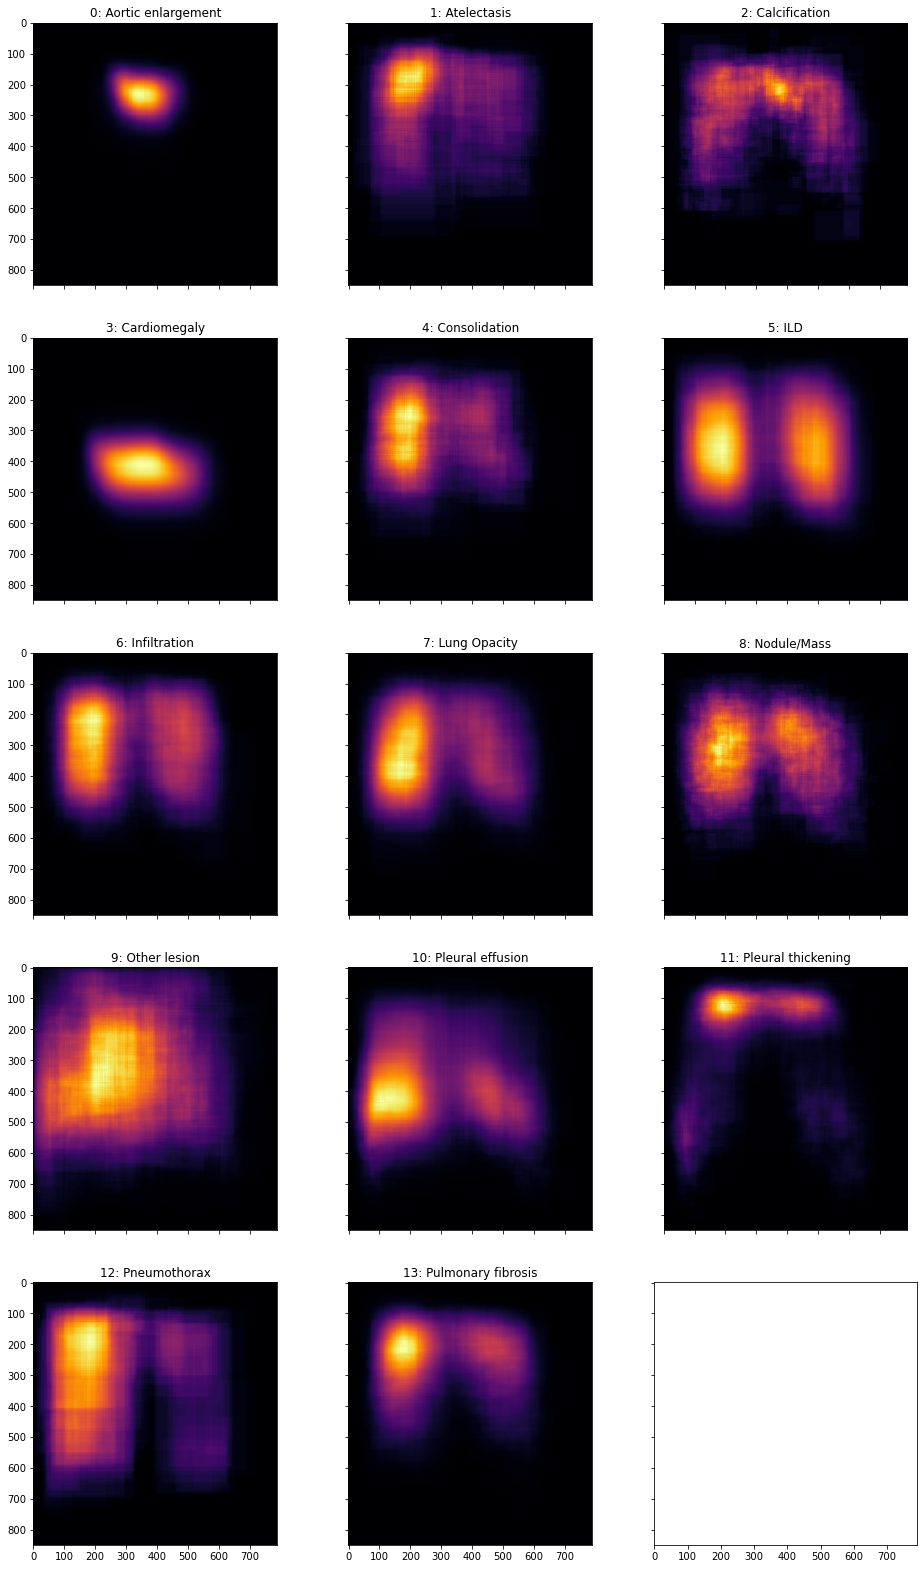

In [111]:
f, axs = plt.subplots(5, 3, sharey=True, sharex=True, figsize=(16,28));

for class_id in range(14):
    axs[class_id // 3, class_id - 3*(class_id // 3)].imshow(locations[class_id], cmap='inferno', interpolation='nearest');
    axs[class_id // 3, class_id - 3*(class_id // 3)].set_title(str(class_id) + ': ' + label_dict[class_id])
    
plt.show();

## Equalizing images

*Histogram equalization is a method in image processing of contrast adjustment using the image's histogram.*

**Before**

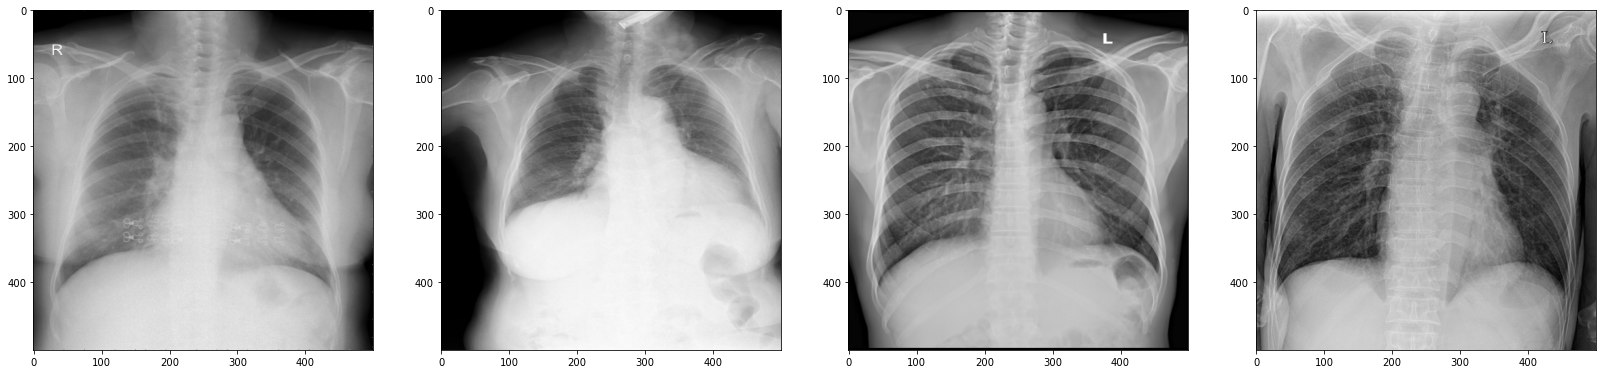

In [120]:
imgs = []
for i in images_list[:4]:
    img = cv2.imread(TRAIN_DIR + '/' + i + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs)

**After**

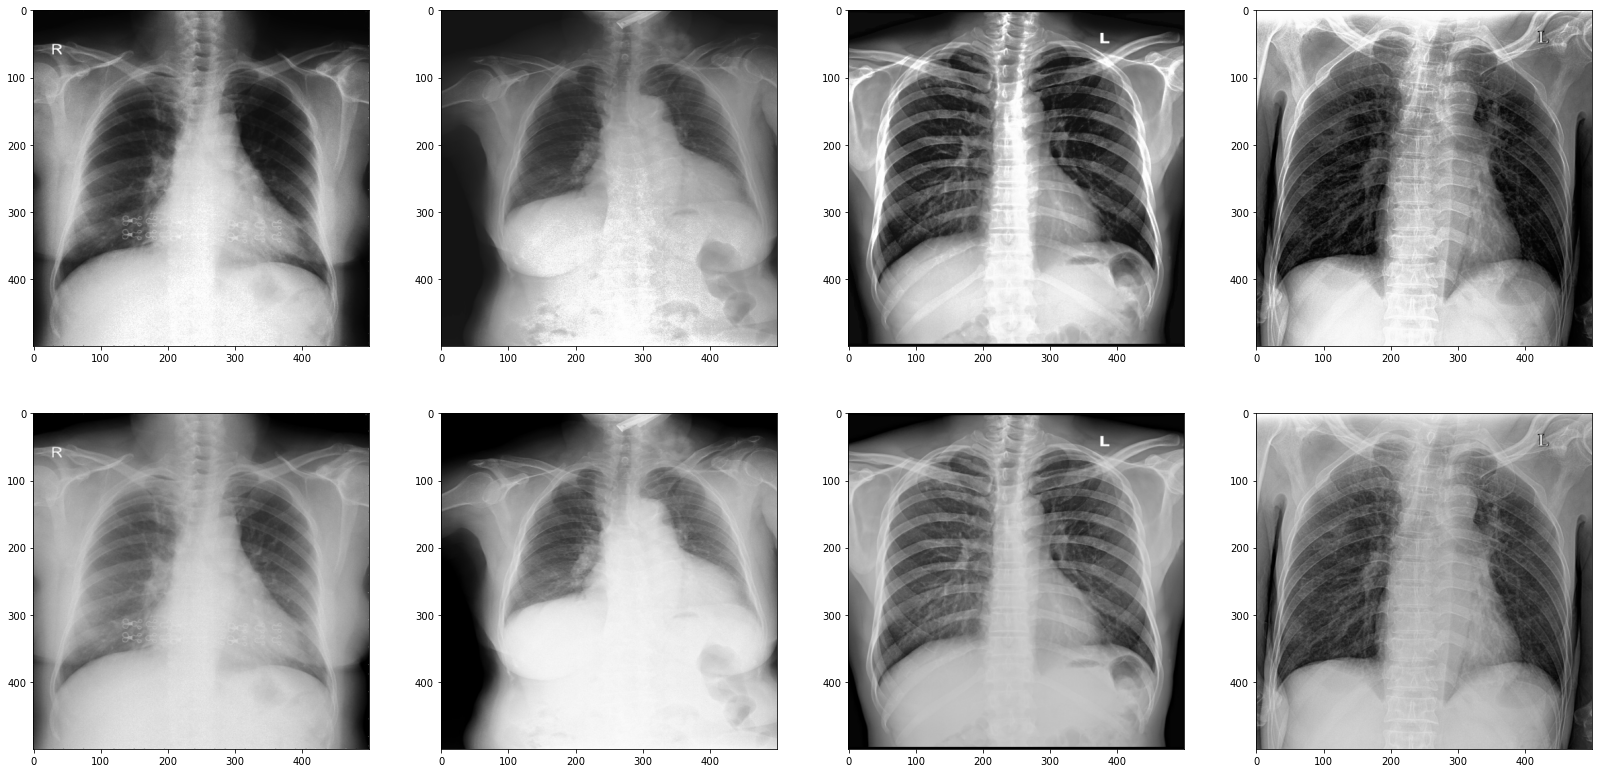

In [121]:
imgs = [exposure.equalize_hist(img) for img in imgs]
for i in images_list[:4]:
    img = cv2.imread(TRAIN_DIR + '/' + i + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs)

## Augmentation

In [150]:
train[train['image_id']=='0108949daa13dc94634a7d650a05c0bb']

image_id          class_name  class_id rad_id  \
19638  0108949daa13dc94634a7d650a05c0bb        Cardiomegaly         3     R8   
33882  0108949daa13dc94634a7d650a05c0bb  Aortic enlargement         0     R8   
41739  0108949daa13dc94634a7d650a05c0bb        Cardiomegaly         3     R9   
47084  0108949daa13dc94634a7d650a05c0bb  Aortic enlargement         0    R10   
48114  0108949daa13dc94634a7d650a05c0bb  Aortic enlargement         0     R9   
59672  0108949daa13dc94634a7d650a05c0bb        Cardiomegaly         3    R10   

       x_min  y_min  x_max  y_max  
19638  193.0  343.0  445.0  438.0  
33882  275.0  183.0  332.0  255.0  
41739  191.0  367.0  450.0  445.0  
47084  275.0  184.0  334.0  233.0  
48114  264.0  183.0  336.0  249.0  
59672  191.0  360.0  449.0  444.0

In [199]:
augs = albumentations.Compose([         
            albumentations.ShiftScaleRotate(rotate_limit=180, p=1)], 
    bbox_params=albumentations.BboxParams(format='pascal_voc'))

In [200]:
img = cv2.imread(TRAIN_DIR + '/' + '0108949daa13dc94634a7d650a05c0bb.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [201]:
transformed = augs(image=img, 
                  bboxes=[[193, 343, 445, 438, 3],
                          [275, 183, 332, 255, 0],], 
                  class_labels=[3, 0]) # Could also provide labels as strings

In [202]:
label2color = {class_id:[np.random.randint(0,255) for i in range(3)] for class_id in class_ids}

In [203]:
for label_id, box in zip([3, 0], np.array([[193, 343, 445, 438],
                          [275, 183, 332, 255]])):
        color = label2color[label_id]
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            color, thickness)

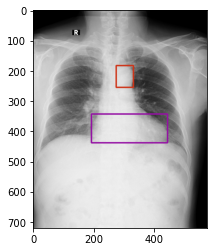

In [204]:
plt.imshow(img)

In [205]:
img_transformed = transformed['image']
labels_transformed = transformed['class_labels']
boxes_transformed = transformed['bboxes']

In [207]:
for label_id, box in zip(labels_transformed, boxes_transformed):
        color = label2color[label_id]
        img_transformed = cv2.rectangle(img_transformed, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            color, thickness)

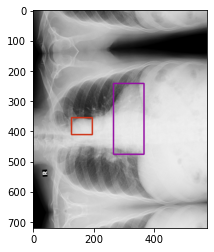

In [208]:
plt.imshow(img_transformed)